In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import xarray as xr
import spatialproteomics as sp
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import gc
import os

In [3]:
metadata = pd.read_csv("2025-01-28_bnhl_metadata.csv", index_col=0)
print(metadata.shape)

(132, 10)


In [4]:
# for this figure, I want to sort by entity and B cell content, but also keep replicates next to one another
# adding the celltype abundances which have been precomputed in the snakemake pipeline
abundance_df = pd.read_csv("/g/huber/users/meyerben/data/codex/BNHL/ct_abundances/ct_abundances_level_0.csv", index_col=0)
# normalizing the cell type abundances per sample
# normalizing per sample so that each sample sums up to one
abundance_df = abundance_df.div(abundance_df.sum(axis=1), axis=0)
# merging with the metadata
df = pd.merge(metadata, abundance_df, left_on='Histo-Nr', right_index=True)

In [5]:
entity_colors = {'LN': '#9dcbec', # light blue
                 'CLL': '#FAD0CE', 'LPL': '#EEBFBD', 'MZL': '#E2AFAC', 
                 'FL 1': '#D59E9C', 'FL 2': '#C98D8B', 'FL 3a': '#BD7C7A', 'FL 3b': '#B16C69', 
                 'MCL': '#A55B58', 'DLBCL': '#994A47', 'PMBCL': '#8C3937', 'Burkitt': '#802926', 'BLBL': '#741815'}

# red, blue, green, yellow, purple, teal (from the nature color palette: https://www.nature.com/documents/natrev-artworkguide.pdf) 
celltype_colors = {'B cell': '#5799d1', 'T cell': '#ebc850', 'Myeloid cell': '#de6866', 'Dendritic cell': '#4cbcbd', 'Macrophage': '#bb7cb4', 'Stromal cell': '#62b346', 'Endothelial cell': '#bf997d'}

# colors for neighborhoods
neighborhood_colors = {'Neighborhood 5': '#5799d1',  # B
                       'Neighborhood 3': '#154e91',  # B prol
                       'Neighborhood 0': '#fef1c3',  # T dendritic
                       'Neighborhood 1': '#ebc850',  # T
                       'Neighborhood 4': '#cca02d',  # T h T reg
                       'Neighborhood 6': '#de6866',  # myeloid macro
                       'Neighborhood 2': '#c8ceda'}  # mixed

# Convert 'entity' column to a categorical type with the custom order
df['Entity'] = pd.Categorical(df['Entity'], categories=entity_colors.keys(), ordered=True)
df = df.sort_values(by=['Entity', 'B cell'])

In [6]:
files = glob("/g/huber/users/meyerben/data/codex/BNHL/zarrs_with_neighborhoods/*")

In [7]:
# === reading the zarrs into the sample dict ===
sample_dict = {}
sample_to_patient_dict = {}
for i, (sample_id_a, sample_id_b, patient_id) in tqdm(df[["sample_id_a", "sample_id_b", "Histo-Nr"]].iterrows()):
    # adding sample a and b to the dictionary if we have images for them
    for sample_id in [sample_id_a, sample_id_b]:
        if pd.isna(sample_id):
            continue
        sample_to_patient_dict[sample_id] = patient_id
        file_mask = [f"{sample_id}.zarr" in x for x in files]
        # print(files)
        # file_mask = [sample_id == x for x in files]
        matching_files = [files[i] for i, mask in enumerate(file_mask) if mask]
        if len(matching_files) != 1:
            raise ValueError(f"Matching files for sample {sample_id}: {matching_files}")
        else:
            file = matching_files[0]
            sample_dict[sample_id] = xr.open_zarr(file)

0it [00:00, ?it/s]

In [8]:
len(sample_dict.keys())

250

In [9]:
def plot_cores_for_entity(entity, background='white'):
    df_subset = df[df['Entity'] == entity]
    num_patients = df_subset.shape[0]

    # plotting all of the cores, with 10 cores per row
    # Determine the number of rows needed
    cores_per_row = num_patients
    num_rows = 2

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, cores_per_row, figsize=(2 * cores_per_row, 2 * num_rows))  # Adjust figsize as needed
    fig.patch.set_facecolor(background)
    
    # Plot each sample
    # this is per patient, replicate 2 is always in the second row
    row, col = 0, 0
    for i, (sample_id_a, sample_id_b) in tqdm(df_subset[["sample_id_a", "sample_id_b"]].iterrows()):
        for sample_id in [sample_id_a, sample_id_b]:
            if pd.isna(sample_id):
                axes[row][col].cla()  # clearing the axis
                axes[row][col].set_facecolor(background)
                axes[row][col].set_xticks([])  # Remove x ticks
                axes[row][col].set_yticks([])  # Remove y ticks
                # Remove the spines
                for spine in axes[row][col].spines.values():
                    spine.set_visible(False)
                row += 1
                continue
                            
            # instead of showing the fine-grained labels here, the coarse ones are enough
            coarse_cts = sample_dict[sample_id].pp.get_layer_as_df('_la_layers')
            coarse_cts['cell'] = coarse_cts.index
            ds = sample_dict[sample_id].pp.drop_layers(['_la_properties', '_neighborhoods']).la.add_labels_from_dataframe(coarse_cts, label_col='labels_0')
            # showing the plot
            ds.pl.autocrop().la.set_label_colors(celltype_colors.keys(), celltype_colors.values()).pl.show(render_image=False, render_labels=True, background=background, legend_label=False, ax=axes[row][col])
            axes[row][col].set_xticks([])  # Remove x ticks
            axes[row][col].set_yticks([])  # Remove y ticks
            
            # Remove the spines
            for spine in axes[row][col].spines.values():
                spine.set_visible(False)
            row += 1
        col += 1
        row = 0
            
    gc.collect()

    # Adjust layout
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/{entity}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

In [10]:
def plot_heterogeneity_for_entity(entity, feature, background='white', vmin=None, vmax=None):
    df_subset = df[df['Entity'] == entity]
    num_patients = df_subset.shape[0]

    # plotting all of the cores, with 10 cores per row
    # Determine the number of rows needed
    cores_per_row = num_patients
    num_rows = 2

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, cores_per_row, figsize=(2 * cores_per_row, 2 * num_rows))  # Adjust figsize as needed
    fig.patch.set_facecolor(background)
    
    # Plot each sample
    # this is per patient, replicate 2 is always in the second row
    row, col = 0, 0
    for i, (sample_id_a, sample_id_b) in tqdm(df_subset[["sample_id_a", "sample_id_b"]].iterrows()):
        for sample_id in [sample_id_a, sample_id_b]:
            if pd.isna(sample_id):
                axes[row][col].cla()  # clearing the axis
                axes[row][col].set_facecolor(background)
                axes[row][col].set_xticks([])  # Remove x ticks
                axes[row][col].set_yticks([])  # Remove y ticks
                # Remove the spines
                for spine in axes[row][col].spines.values():
                    spine.set_visible(False)
                row += 1
                continue
                            
            # instead of showing the fine-grained labels here, the coarse ones are enough
            coarse_cts = sample_dict[sample_id].pp.get_layer_as_df('_la_layers')
            coarse_cts['cell'] = coarse_cts.index
            ds = sample_dict[sample_id]
            # showing the plot
            ds.pl.autocrop().pl.render_obs(feature=feature, background=background, cmap='magma', vmin=vmin, vmax=vmax).pl.imshow(ax=axes[row][col])
            axes[row][col].set_xticks([])  # Remove x ticks
            axes[row][col].set_yticks([])  # Remove y ticks
            
            # Remove the spines
            for spine in axes[row][col].spines.values():
                spine.set_visible(False)
            row += 1
        col += 1
        row = 0
            
    gc.collect()

    # Adjust layout
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/{feature}_{entity}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

In [11]:
def plot_neighborhoods_for_entity(entity, background='white'):
    df_subset = df[df['Entity'] == entity]
    num_patients = df_subset.shape[0]

    # plotting all of the cores, with 10 cores per row
    # Determine the number of rows needed
    cores_per_row = num_patients
    num_rows = 2
    
     # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, cores_per_row, figsize=(2 * cores_per_row, 2 * num_rows))  # Adjust figsize as needed
    fig.patch.set_facecolor(background)
    
    # Plot each sample
    # this is per patient, replicate 2 is always in the second row
    row, col = 0, 0
    for i, (sample_id_a, sample_id_b) in tqdm(df_subset[["sample_id_a", "sample_id_b"]].iterrows()):
        for sample_id in [sample_id_a, sample_id_b]:
            if pd.isna(sample_id):
                axes[row][col].cla()  # clearing the axis
                axes[row][col].set_facecolor(background)
                axes[row][col].set_xticks([])  # Remove x ticks
                axes[row][col].set_yticks([])  # Remove y ticks
                # Remove the spines
                for spine in axes[row][col].spines.values():
                    spine.set_visible(False)
                row += 1
                continue
                            
            # instead of showing the fine-grained labels here, the coarse ones are enough
            coarse_cts = sample_dict[sample_id].pp.get_layer_as_df('_la_layers')
            coarse_cts['cell'] = coarse_cts.index
            ds = sample_dict[sample_id]
            # showing the plot
            (ds.pl.autocrop()
                  .nh.set_neighborhood_colors(neighborhood_colors.keys(), neighborhood_colors.values())
                  .pl.show(render_image=False, render_neighborhoods=True, legend_neighborhoods=False, background=background, ax=axes[row][col]))
            axes[row][col].set_xticks([])  # Remove x ticks
            axes[row][col].set_yticks([])  # Remove y ticks
            
            # Remove the spines
            for spine in axes[row][col].spines.values():
                spine.set_visible(False)
            row += 1
        col += 1
        row = 0
            
    gc.collect()

    # Adjust layout
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/neighborhoods_{entity}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

In [ ]:
entities = ['LN', 'MZL', 'FL 1', 'FL 2', 'FL 3a', 'FL 3b', 'DLBCL', 'PMBCL', 'Burkitt', 'BLBL']

for entity in entities:
    print(entity)
    if not os.path.exists(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/{entity}.png'):
        plot_cores_for_entity(entity, background='#e6e6ed')
        gc.collect()
    #if not os.path.exists(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/diversity_index_{entity}.png'):
    #    plot_heterogeneity_for_entity(entity, feature='diversity_index', background='#e6e6ed', vmin=0, vmax=2.53)
    #    gc.collect()
    #if not os.path.exists(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/degree_{entity}.png'):
    #    plot_heterogeneity_for_entity(entity, feature='degree', background='#e6e6ed', vmin=0, vmax=70)  # 70 is the maximum in the dataset
    #    gc.collect()
    if not os.path.exists(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/neighborhoods_{entity}.png'):
        plot_neighborhoods_for_entity(entity, background='#e6e6ed')
        gc.collect()   

LN


0it [00:00, ?it/s]

Removing labels from observations. If you want to keep the labels in the obs layer, set drop_obs=False.
Removing labels from observations. If you want to keep the labels in the obs layer, set drop_obs=False.
Removing labels from observations. If you want to keep the labels in the obs layer, set drop_obs=False.
Removing labels from observations. If you want to keep the labels in the obs layer, set drop_obs=False.
Removing labels from observations. If you want to keep the labels in the obs layer, set drop_obs=False.
Removing labels from observations. If you want to keep the labels in the obs layer, set drop_obs=False.
Removing labels from observations. If you want to keep the labels in the obs layer, set drop_obs=False.
Removing labels from observations. If you want to keep the labels in the obs layer, set drop_obs=False.
Removing labels from observations. If you want to keep the labels in the obs layer, set drop_obs=False.
Removing labels from observations. If you want to keep the label

0it [00:00, ?it/s]

Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 2 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the dat

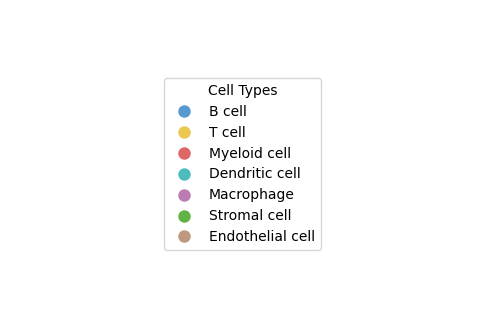

In [11]:
# creating a legend

# Create an empty plot
fig, ax = plt.subplots(figsize=(6, 4))

# Create the legend handles
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in celltype_colors.values()]

# Create the legend
ax.legend(handles, celltype_colors.keys(), title="Cell Types", loc='center')

# Hide the axes
ax.axis('off')

# Display the legend
plt.savefig(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/legend.png', bbox_inches='tight', pad_inches=0)
# plt.show()

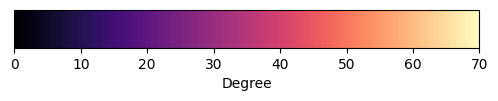

In [14]:
# legend for degrees
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define the range and the color map
vmin, vmax = 0, 70
cmap = plt.cm.magma

# Create a colorbar
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Create a scalar mappable object
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar

# Add the colorbar to the plot
cbar = plt.colorbar(sm, cax=ax, orientation="horizontal")
cbar.set_label("Degree")

# Display the colorbar
plt.show()

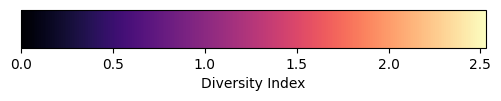

In [10]:
# legend for degrees
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define the range and the color map
vmin, vmax = 0, 2.53
cmap = plt.cm.magma

# Create a colorbar
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Create a scalar mappable object
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar

# Add the colorbar to the plot
cbar = plt.colorbar(sm, cax=ax, orientation="horizontal")
cbar.set_label("Diversity Index")

# Display the colorbar
plt.show()

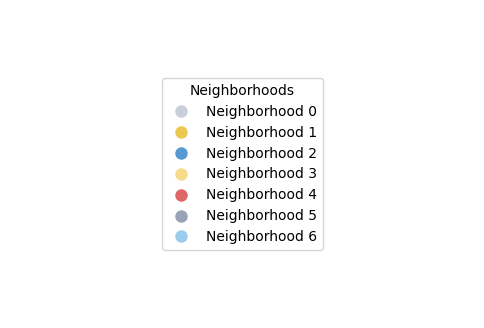

In [22]:
# creating a legend

# Create an empty plot
fig, ax = plt.subplots(figsize=(6, 4))

# Create the legend handles
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in neighborhood_colors.values()]

# Create the legend
ax.legend(handles, neighborhood_colors.keys(), title="Neighborhoods", loc='center')

# Hide the axes
ax.axis('off')

# Display the legend
# plt.savefig(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/neighborhood_legend.png', bbox_inches='tight', pad_inches=0)
plt.show()

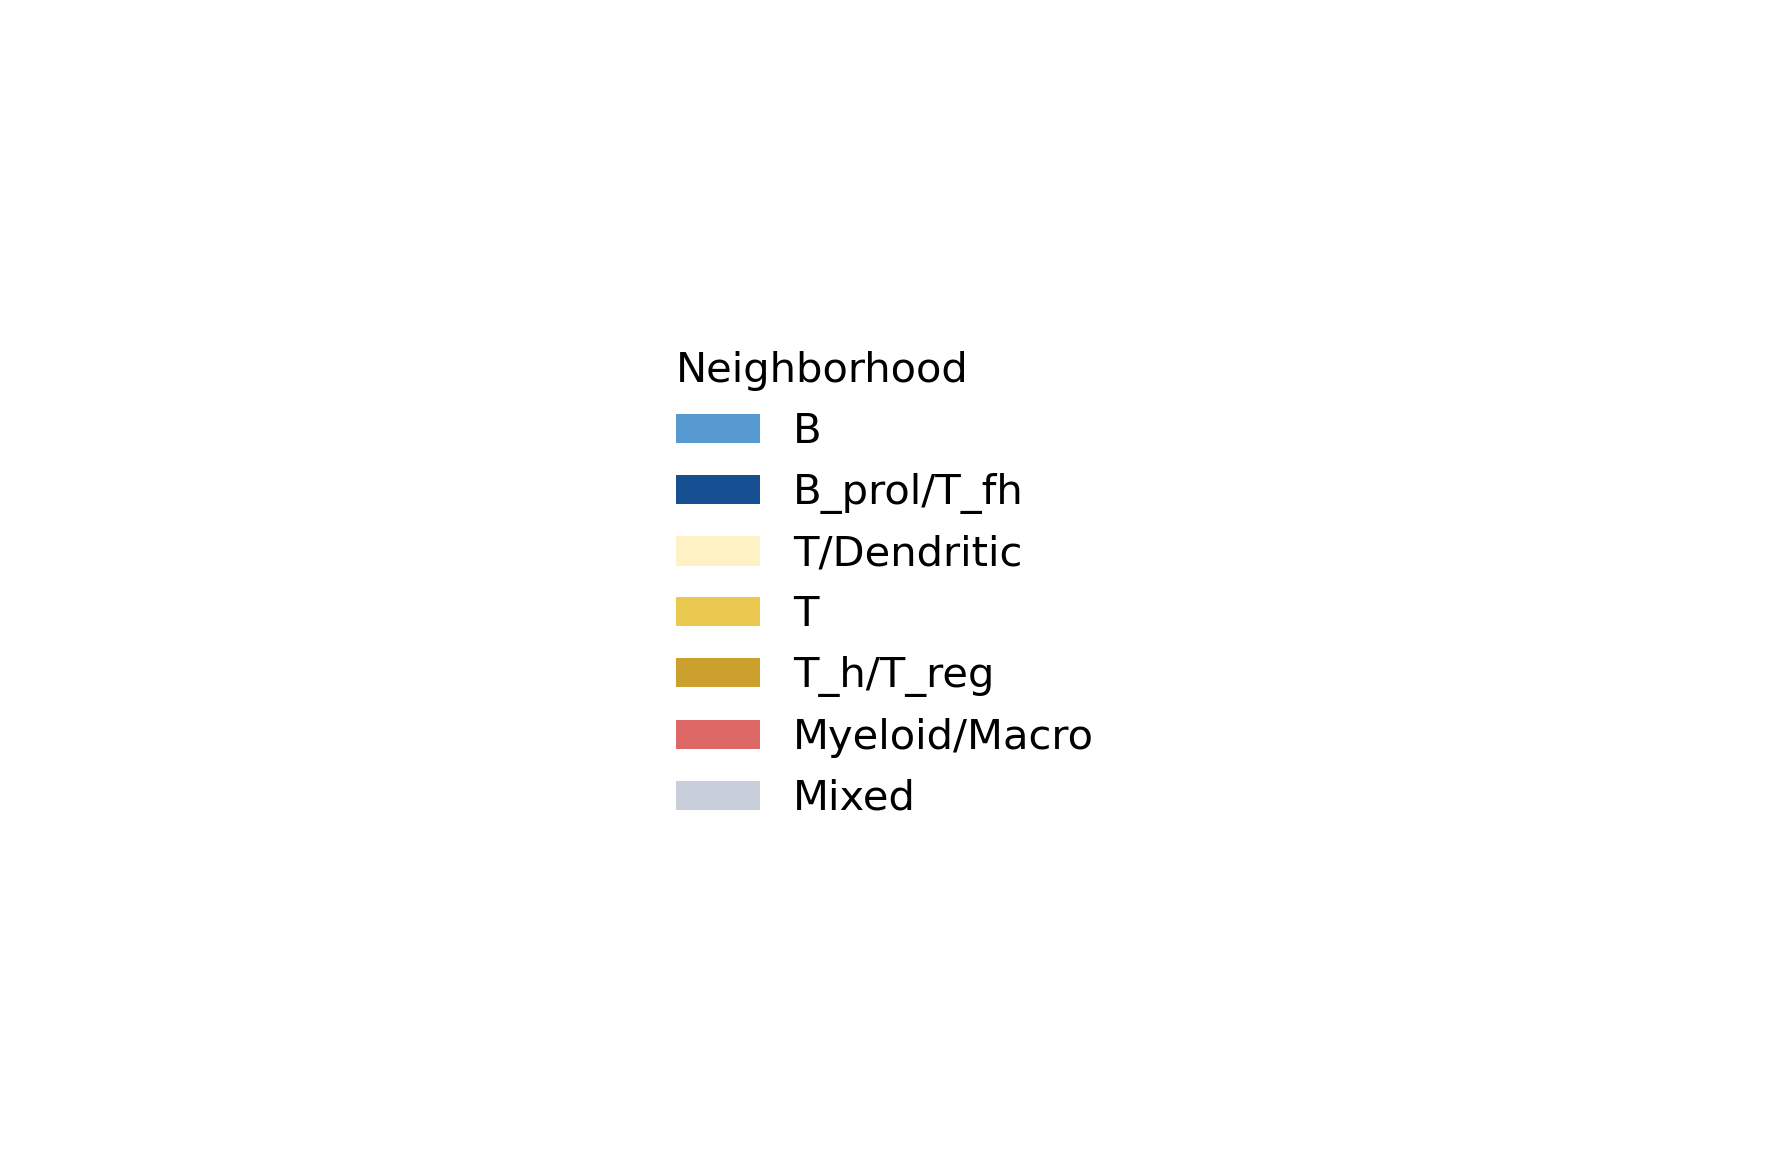

In [29]:
from matplotlib.patches import Patch

neighborhood_colors = {'B': '#5799d1',
                       'B_prol/T_fh': '#154e91',
                       'T/Dendritic': '#fef1c3',
                       'T': '#ebc850',
                       'T_h/T_reg': '#cca02d',
                       'Myeloid/Macro': '#de6866',
                       'Mixed': '#c8ceda'}

# Create an empty plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Create the legend handles
handles = [
    Patch(facecolor=color, edgecolor='none', label=label)
    for label, color in neighborhood_colors.items()
]

# Create the legend
legend = ax.legend(handles, neighborhood_colors.keys(), title="Neighborhood", loc='center', frameon=False)

legend._legend_box.align = "left"

# Hide the axes
ax.axis('off')

plt.tight_layout()

# Display the legend
plt.savefig(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/neighborhood_legend.svg', bbox_inches='tight', pad_inches=0)
# plt.show()

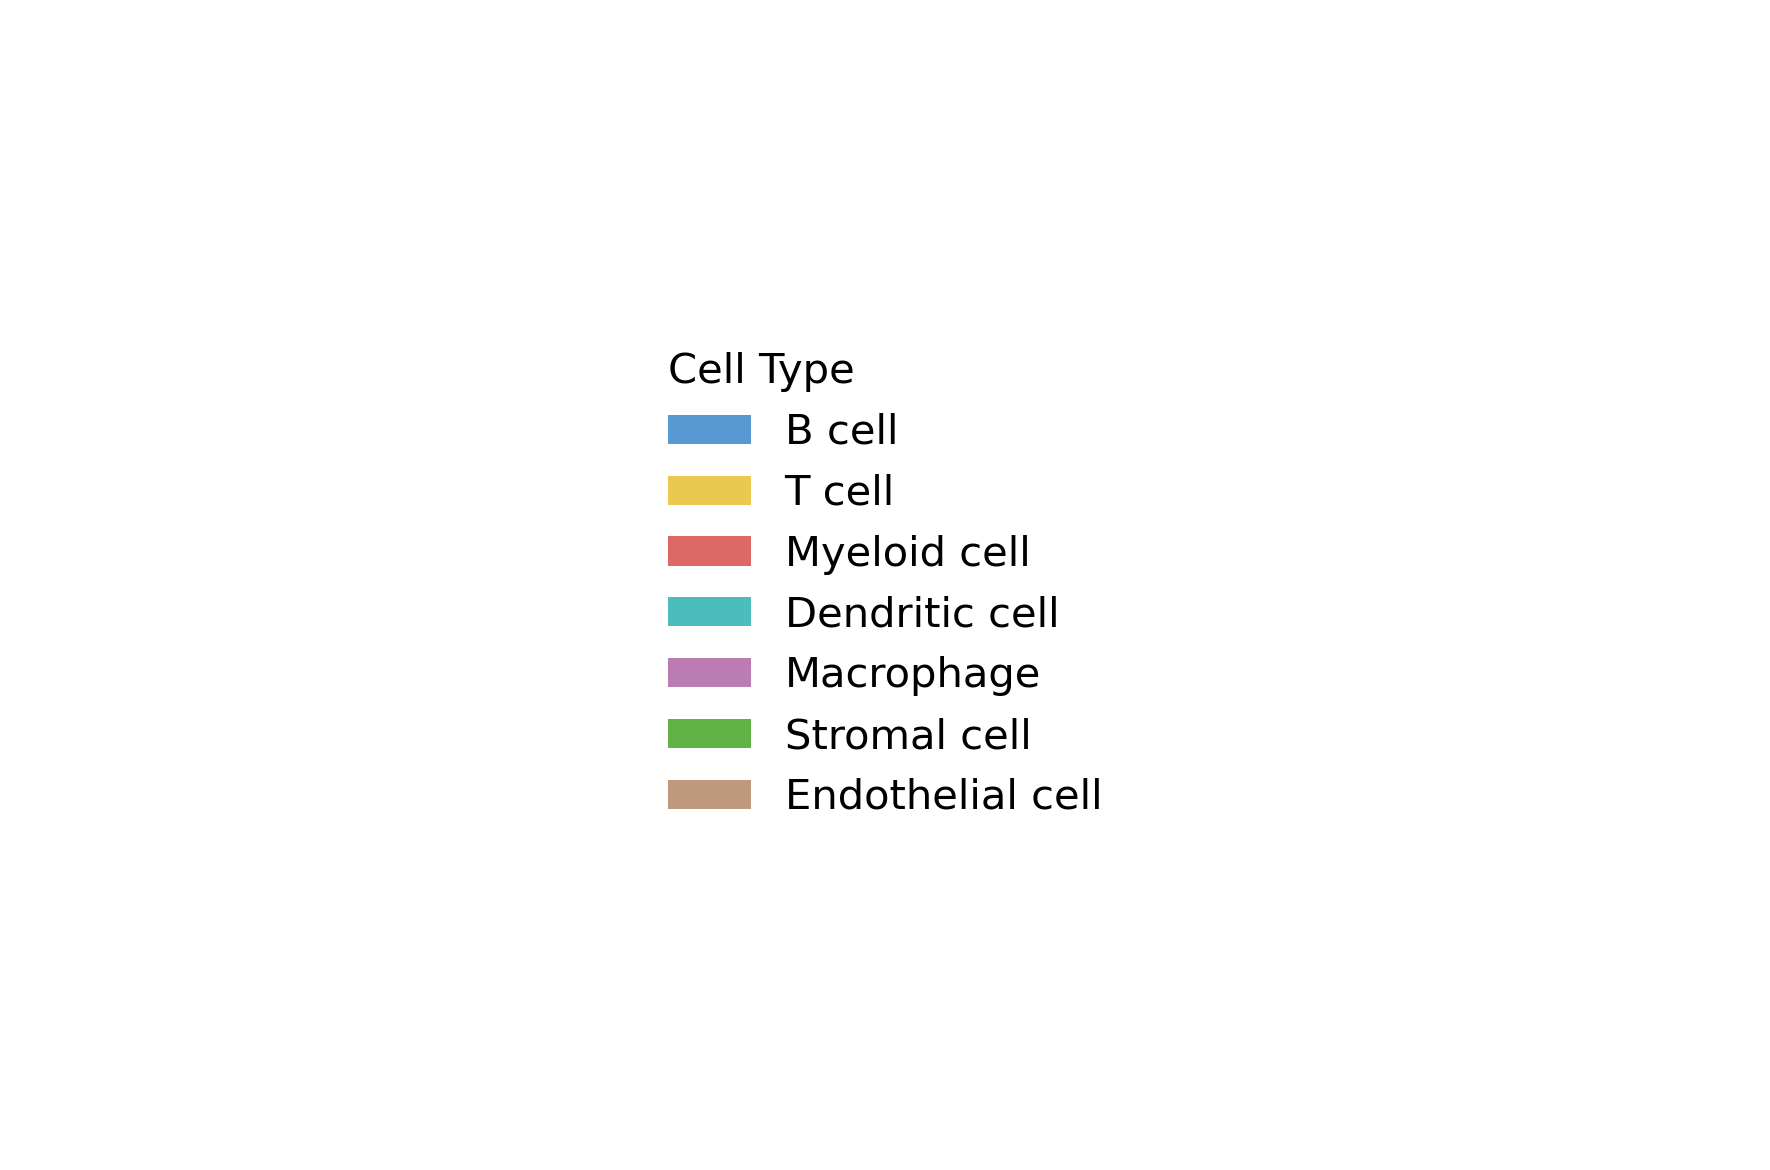

In [30]:
# Create an empty plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Create the legend handles
# handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in celltype_colors.values()]
handles = [
    Patch(facecolor=color, edgecolor='none', label=label)
    for label, color in celltype_colors.items()
]

# Create the legend
legend = ax.legend(handles, celltype_colors.keys(), title="Cell Type", loc='center', frameon=False)

legend._legend_box.align = "left"

# Hide the axes
ax.axis('off')

plt.tight_layout()

# Display the legend
plt.savefig(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/label_legend.svg', bbox_inches='tight', pad_inches=0)
# plt.show()

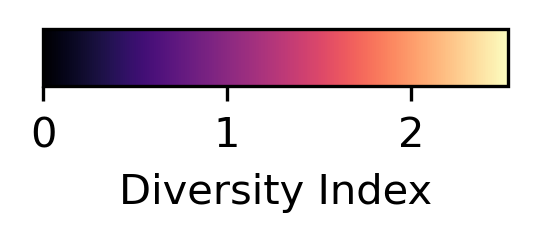

In [27]:
# legend for degrees
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define the range and the color map
vmin, vmax = 0, 2.53
cmap = plt.cm.magma

# Create a colorbar
fig, ax = plt.subplots(figsize=(2, 0.5), dpi=300)
fig.subplots_adjust(bottom=0.5)

# Create a scalar mappable object
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar

# Add the colorbar to the plot
cbar = plt.colorbar(sm, cax=ax, orientation="horizontal")
cbar.set_label("Diversity Index")

# Display the colorbar
plt.savefig(f'/g/huber/users/meyerben/data/codex/BNHL/core_images/diversity_index_legend.svg', bbox_inches='tight', pad_inches=0)
# plt.show()